In [ ]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ["CUDA_VISIBLE_DEVICES"] = '3' 

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [ ]:
# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [ ]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

In [ ]:
best_exp = rs.get_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    metric="val-dice_score",
    checkpoint="max-val-dice_score",
    device="cuda"
)

In [ ]:
best_exp.vis_loss_curves(height=6)

In [ ]:
%%yaml dataset_cfg 

_class: ese.experiment.datasets.WMH
annotator: observer_o12
axis: 0
split: val 
num_slices: 1
slicing: midslice 
task: Amsterdam 
version: 0.2

In [ ]:
from ionpy.experiment.util import absolute_import
from torch.utils.data import DataLoader

dataset_cls = absolute_import(dataset_cfg.pop("_class"))
WMH_Dataset = dataset_cls(**dataset_cfg)
wmh_dataloader = DataLoader(WMH_Dataset, batch_size=1, shuffle=False, drop_last=False)

In [ ]:
from ionpy.util.torchutils import to_device
import torch
from tqdm.notebook import tqdm
import einops

def get_dataset_perf(
        exp, 
        dataloader, 
        ):

    items = []
    with torch.no_grad():
        for _, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            # Get your image label pair and define some regions.
            x, y = to_device(batch, exp.device)
            # Reshape to a good size
            x = einops.rearrange(x, "b c h w -> (b c) 1 h w")
            y = einops.rearrange(y, "b c h w -> (b c) 1 h w")
            # Get the prediction
            yhat = exp.model(x)  
            # Extract predictions
            soft_pred = torch.sigmoid(yhat)
            # Get the hard prediction
            hard_pred = (soft_pred > 0.5).float()
            # Wrap it in an item
            items.append({
                "image": x.cpu().squeeze(),
                "label": y.cpu().squeeze(),
                "soft_pred": soft_pred.cpu().squeeze(),
                "hard_pred": hard_pred.cpu().squeeze(),
            })

    return items

In [ ]:
# val_perf is a dict where each item is the subj id
# with the y, ypred, yloss, ydice
predictions_dict = get_dataset_perf(
    exp=best_exp, 
    dataloader=wmh_dataloader
    )

KeyboardInterrupt: 

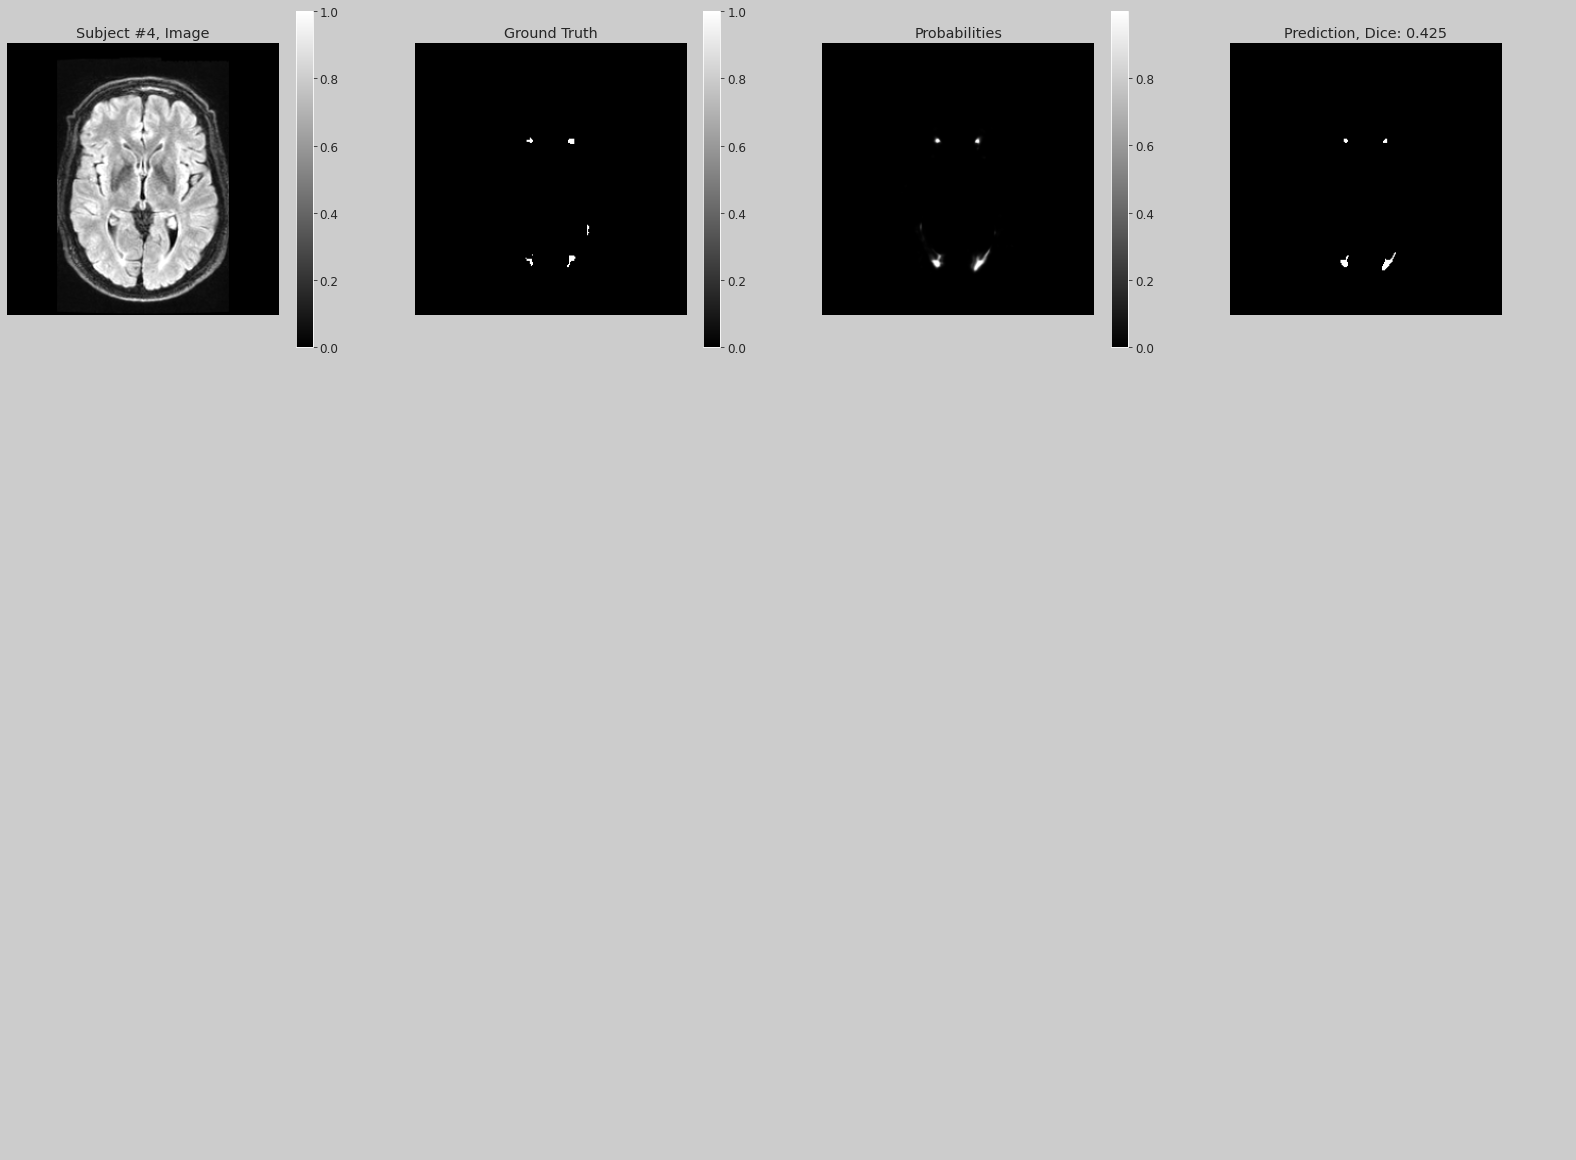

In [10]:
from ese.experiment.analysis.diagrams import subject_plot

subject_plot(
    subject_dict=predictions_dict,
    num_bins=10,
    show_bin_amounts=False,
    metrics=["ECE", "ReCE"],
    bin_weightings=["weighted"]
)

In [ ]:
from ese.experiment.analysis.diagrams import aggregate_reliability_plot 

aggregate_reliability_plot(
    subject_dict=predictions_dict,
    num_bins=10,
    metrics=["ECE", "ReCE"],
    bin_weightings=["weighted"]
)

In [ ]:
from ese.experiment.analysis.diagrams import aggregate_cm_plot

aggregate_cm_plot(
    subj_dict=predictions_dict
)

In [ ]:
from ese.experiment.analysis.diagrams import aggregate_error_distribution_plot

aggregate_error_distribution_plot(
    subject_dict=predictions_dict,
    num_bins=10,
    metrics=["ECE", "ReCE"],
    bin_weightings=["weighted"]
)